In [4]:
cd
build_path niak psom
cd /home/pbellec/git/niak_tutorials/glm_connectome

Adding library niak to the search path.

Adding library psom to the search path.



# GLM connectome pipeline - model visualization
This tutorial shows how to visualize the models used in the NIAK GLM connectome pipeline. Download the tutorial as a notebook [here](https://raw.githubusercontent.com/SIMEXP/niak_tutorials/master/glm_connectome/niak_tutorial_glm_connectome_visu_model.ipynb) and a matlab script [here](https://raw.githubusercontent.com/SIMEXP/niak_tutorials/master/connectome/niak_tutorial_glm_connectome_visu_model.m). To run this tutorial, we recommend to use [jupyter](http://jupyter.org/) from a niak docker container, as described in the [NIAK installation page](http://niak.simexp-lab.org/niak_installation.html). 

We will illustrate the model construction and visualization on the COBRE data. We will first download it.  

In [5]:
clear
path_data = [pwd filesep];
[status,msg,data_fmri] = niak_wget('cobre_lightweight20_nii');

## Group model
### Creating a spreadsheet

You can create your model using any spreadsheet software (e.g. Excel, Google spreadsheet, etc) or even a text editor. The spreadsheet will look like:
```
      , age , patient , fd
40061 , 18  , 0       , 0.22657 
40117 , 19  , 1       , 0.18410 
40145 , 19  , 1       , 0.15521
```
The first line defines labels for the explanatory variables. Here we have three variables: `age` is self-explanatory, `patient` is a binary variable coding for the diagnostic status, and `fd` is an overall measure of motion during the fMRI scan, called frame displacement.

The first column corresponds to subject labels. Those can be numbers or strings, but they need to be identical to the labels used in the GLM connectome pipeline. In the case you are "grabbing" data generated by the NIAK fMRI preprocessing pipeline, the labels need to be consistent with the ones used in the fMRI preprocessing pipeline. **Note** the first cell (i.e first row and column) need to be left empty. 

Finally all other values are numerical. For example, for the `patient` variable, 1 codes for a patient with schizophrenia, and 0 for a healthy control. You do not need to have a variable for the intercept, or to demean variables. You also do not need to create interaction variables, or to create a separate model for different subgroup of subjects. All these operations will be done when describing a particular "contrast" in the GLM connectome pipeline.  

### Building a model from an existing spreadsheet 
You can build a group model from an existing spreadsheet using NIAK. We will start from `.csv` phenotypic variable available in the COBRE sample. 

In [13]:
path_cobre = [pwd filesep 'cobre_lightweight20'];
file_pheno = [path_cobre filesep 'phenotypic_data.tsv.gz'];
tab = niak_read_csv_cell(file_pheno);

In [ ]:
list_subject = tab(2:end,1);
list_var = { 'age' , 'patient' , 'fd' };

Now we convert the values into a series of numerical covariates:

In [14]:
patient = strcmp(tab(2:end,5),'Patient');
age = str2double(tab(2:end,2)); 
FD = str2double(tab(2:end,9));

We save the model in a separate .csv file:

In [20]:
file_model_group = [pwd filesep 'model_patient.csv']; % The file name for the .csv group model
opt_csv.labels_x = list_subject; % Labels for the rows
opt_csv.labels_y = list_var; % Labels for the columns
niak_write_csv('model_patient.csv', [age patient FD] , opt_csv);

## Visualization of the group model

 and make sure it can be loaded properly with NIAK. The model is loaded in three variables:

In [16]:
[X_group,list_subject,list_var] = niak_read_csv(files_in.model.group);

The `list_subject` and `list_var` are cell of strings that describe the subject (row) labels, and explanatory variables (column) labels, respectively: 

In [18]:
list_subject(1:3)
list_var
X_group(1:3,:)

ans = 
{
  [1,1] = 40061
  [2,1] = 40117
  [3,1] = 40145
}
list_var = 
{
  [1,1] = age
  [2,1] = patient
  [3,1] = fd
}
ans =

   18.00000    0.00000    0.22657
   19.00000    1.00000    0.18410
   19.00000    1.00000    0.15521



Here we have three variables: `age` is self-explanatory, `patient` is a binary variable coding for the diagnostic status (0 for controls, 1 for patients), and `fd` is an overall measure of motion during the fMRI scan, called frame displacement. Because the variables have very different ranges, we will normalize each variable to a zero mean and unit variance. We can visualize the data associated with the three variables as follows:

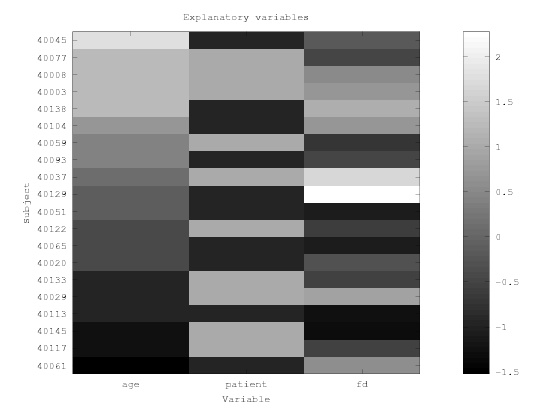

In [21]:
figure
% Normalize data
X_group_n = niak_normalize_tseries(X_group);
% That is making the figure
imagesc(X_group_n)
% Set title for figure and axes
title('Explanatory variables')
xlabel('Variable')
ylabel('Subject')
% Set subject and variable labels on each axis
ha = gca;
set(ha,'xtick',1:length(list_var))
set(ha,'ytick',1:length(list_subject))
set(ha,'xticklabel',list_var)
set(ha,'yticklabel',list_subject)
% Add a colorbar and a gray colormap
colormap gray
colorbar

 We can compute the correlation between our three explanatory variables:

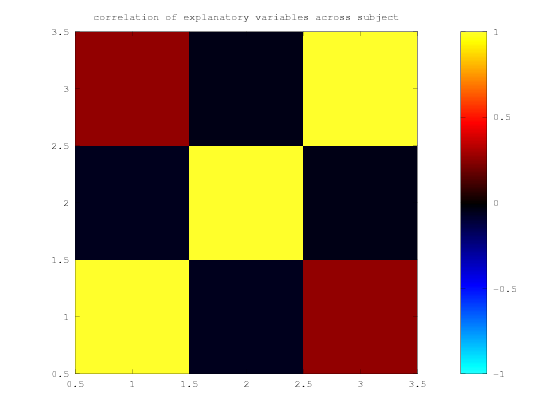

In [26]:
Rx = corr(X_group);
niak_visu_matrix(Rx);
title('correlation of explanatory variables across subject')

# Connectivity maps

Now we are going to get a list of the connectivity maps associated with each subject for one network, say the DMN. Labels for each network have been specified when running the `connectome` pipeline. We simply grab the outputs of the connectome pipeline. 

In [ ]:
path_connectome = [pwd filesep 'connectome'];
files_conn = niak_grab_connectome(path_connectome);
files_in.data = files_conn.rmap;

## Brain mask
We specify the mask of brain networks to the pipeline, so that it can use it to mask the grey matter. 

In [ ]:
files_in.mask = files_conn.network_rois;

# Set up the options of the pipeline

First specify where to save the outputs, and how many networks to use: 

In [ ]:
%% General
opt.folder_out = [pwd filesep 'subtype'];    

Then specify which covariates to use as confounds **before** the generation of subtypes. 

In [ ]:
% a list of variable names to be regressed out
% If unspecified or left empty, no confounds are regressed
opt.stack.regress_conf = {'fd'};     

The options for the subtypes themselves:

In [ ]:
%% Subtyping
opt.subtype.nb_subtype = 2;        % the number of subtypes to extract
opt.subtype.sub_map_type = 'mean'; % the model for the subtype maps (options are 'mean' or 'median')

Now we add an association test between subtypes and the patient label:

In [ ]:
% scalar number for the level of acceptable false-discovery rate (FDR) for the t-maps
opt.association.patient.fdr = 0.05;                           
% turn on/off normalization of covariates in model (true: apply / false: don't apply)
opt.association.patient.normalize_x = false;                   
% turn on/off normalization of all data (true: apply / false: don't apply)
opt.association.patient.normalize_y = false;                  
% turn on/off adding a constant covariate to the model
opt.association.patient.flag_intercept = true;     
% To test a main effect of a variable
opt.association.patient.contrast.patient = 1; % scalar number for the weight of the variable in the contrast
opt.association.patient.contrast.fd = 0;      % scalar number for the weight of the variable in the contrast
opt.association.patient.contrast.age = 0;     % scalar number for the weight of the variable in the contrast
% type of data for visulization (options are 'continuous' or 'categorical')
opt.association.patient.type_visu = 'continuous'; 

It is also possible to add a single chi-square test on the relationship between subtypes and a categorical variable:

In [ ]:
% string name of the column in files_in.model on which the contigency table will be based
opt.chi2 = 'patient';    

# Run the pipeline

In [ ]:
opt.flag_test = false;  % Put this flag to true to just generate the pipeline without running it.
pipeline = niak_pipeline_subtype(files_in,opt);